In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
import pygeos
import rtree

/Users/Safia/.pyenv/versions/3.8.12/envs/school-map-project/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [3]:
df = gpd.read_file('../raw_data/Maps/social_data_pr.shp')

In [4]:
df.Name

0                 Karlshorst Süd
1            Immanuelkirchstraße
2       Tirschenreuther Ring Ost
3                    Wismarplatz
4             Märkisches Zentrum
                 ...            
537                Wittenau Nord
538                 Blankenfelde
539             Pilgramer Straße
540                   Hasenheide
541    Hohenschönhausener Straße
Name: Name, Length: 542, dtype: object

In [5]:
df.crs

<Derived Projected CRS: EPSG:25833>
Name: ETRS89 / UTM zone 33N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 12°E and 18°E: Austria; Denmark - offshore and offshore; Germany - onshore and offshore; Norway including Svalbard - onshore and offshore.
- bounds: (12.0, 46.4, 18.0, 84.42)
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [11]:
df["PLR_ID"] = df.Nummer

### Creating a migration rate variable

In [12]:
df['MH_rate'] = df.MH_E / df.E_E

In [13]:
df['MH_rate'].mean()

0.3498408646096005

In [14]:
df['MH_E'].sum() / df['E_E'].sum()

0.3569203165575865

### Creating a population density column

**Computing polygon areas**

In [15]:
df['area'] = df.geometry.area

**Calculating population density**

In [18]:
df['pop_dens'] = df['E_E'] / df['area']

In [19]:
df.wohndauer

0      62.319997
1      61.167671
2      71.059997
3      52.409999
4      69.899998
         ...    
537    69.899997
538    68.998478
539    76.559977
540    62.900546
541    62.090170
Name: wohndauer, Length: 542, dtype: float64

### Calculating population age rates

In [20]:
bins = ['E_EM', 'E_EW', 'E_EU1', 'E_E1U6', 'E_E6U15', 'E_E15U18',
       'E_E18U25', 'E_E25U55', 'E_E55U65', 'E_E65U80', 'E_E80U110']

for b in bins: 
    df[b] = df[b] / df.E_E

In [21]:
bins = ['MH_EM', 'MH_EW', 'MH_U1', 'MH_1U6', 'MH_6U15', 'MH_15U18', 'MH_18U25',
       'MH_25U55', 'MH_55U65', 'MH_65U80', 'MH_80U110']

for b in bins: 
    df[b] = df[b] / df.MH_E

<AxesSubplot:xlabel='pop_dens', ylabel='Count'>

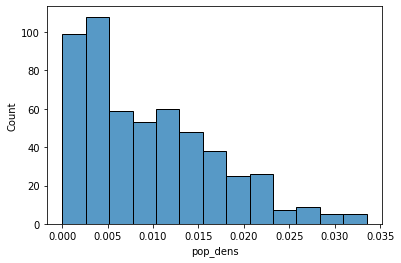

In [22]:
sns.histplot(df['pop_dens'])

In [25]:
df.to_file('../raw_data/Maps/dataset.shp')

In [14]:
columns = ['E_EM', 'E_EW', 'E_EU1', 'E_E1U6', 'E_E6U15', 'E_E15U18',
       'E_E18U25', 'E_E25U55', 'E_E55U65', 'E_E65U80', 'E_E80U110', 'MH_E',
       'MH_EM', 'MH_EW', 'MH_U1', 'MH_1U6', 'MH_6U15', 'MH_15U18', 'MH_18U25',
       'MH_25U55', 'MH_55U65', 'MH_65U80', 'MH_80U110', 'angebotsmi',
       'aenderung_', 'anteil_lei', 'anteil_soz', 'anteil_sta', 'entwicklun',
       'wohndauer', 'wohnungsum', 'wohnungs_1', 'wohnungsve', 'wohnungs_2',
       'ant_arbeit', 'ant_transf', 'Kinderarmu',
       'ant_arbe_1', 'ant_tran_1', 'Kinderar_1','MH_rate','pop_dens']

'for c in columns:\n    plt.subplot()\n    sns.histplot(df[c])'

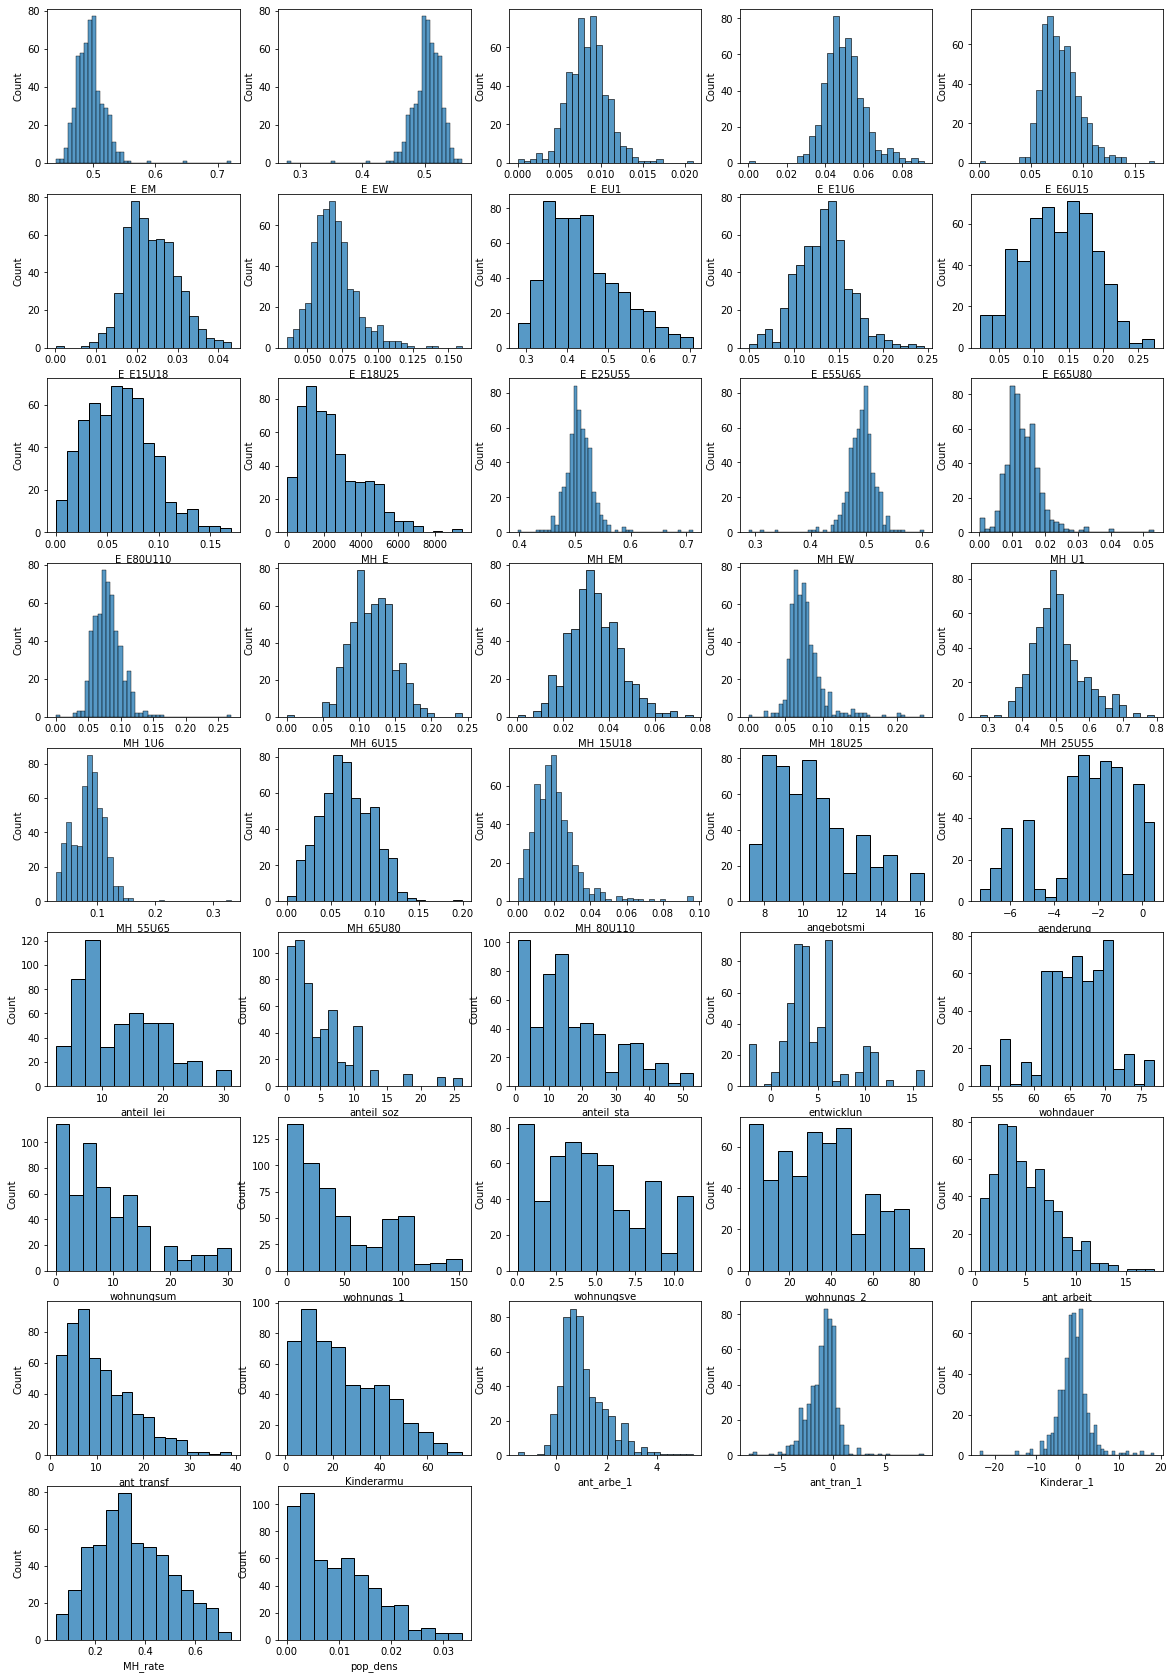

In [36]:
nrows= 9
ncols = 5
count=1

plt.figure(figsize=(20,30))

for c in columns: 
    plt.subplot(nrows, ncols, count)
    sns.histplot(df[c])
    count +=1

plt.show


# Merging OSM features and PR

## Creating a GeoDataFrame with OSM features

In [80]:
df_osm = gpd.read_file('../raw_data/social_eating.csv')

In [81]:
df_osm

,lat,lon,coor,geometry
0,52.506911,13.3228214,"(52.506911, 13.3228214)",None
1,52.5062119,13.3180811,"(52.5062119, 13.3180811)",None
2,52.5073199,13.3207804,"(52.5073199, 13.3207804)",None
3,52.5063184,13.2846256,"(52.5063184, 13.2846256)",None
4,52.5388551,13.3960965,"(52.5388551, 13.3960965)",None
...,...,...,...,...
6774,52.5334984,13.3663195,"(52.5334984, 13.3663195)",None
6775,52.5041511,13.3294444,"(52.5041511, 13.3294444)",None
6776,52.501496,13.4188985,"(52.501496, 13.4188985)",None
6777,52.494043,13.3833987,"(52.494043, 13.3833987)",None


In [82]:
df_osm.drop(columns='geometry', inplace=True)

In [136]:
geo_df = gpd.GeoDataFrame(df_osm, geometry=gpd.points_from_xy(df_osm.lon, df_osm.lat), crs='epsg:4326')

## Filtering the results

In [119]:
geo_df.lat.min()

'38.3239831'

In [137]:
geo_df['lat_num'] = geo_df.lat.astype(np.longdouble)

geo_df['lon_num'] = geo_df.lon.astype(float)

geo_df_right = geo_df[(geo_df.lat_num>50) & (geo_df.lon_num > 12)]

geo_df_right.to_crs(crs='epsg:25833', inplace=True)

## Making spatial join intersects and nearest with PR 

<AxesSubplot:>

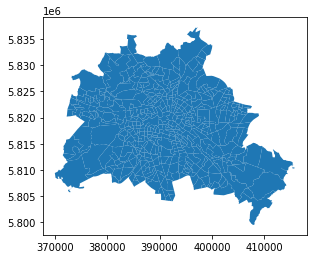

In [170]:
pr_2021 = gpd.read_file('../raw_data/Maps/pr_2021.shp')

pr_2021.plot()

<AxesSubplot:>

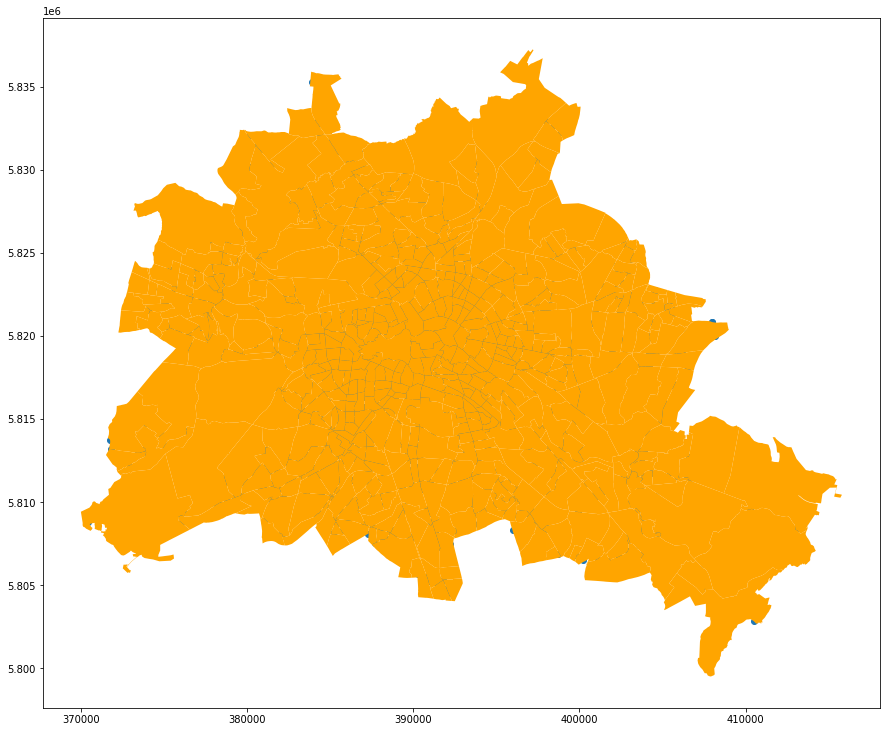

In [171]:
fig, ax = plt.subplots(figsize=(15, 15))
geo_df_right.plot(ax=ax)
df.plot(ax = ax, color='orange')

In [174]:
nearest = geo_df_right.sjoin_nearest(pr_2021, how='left')
nearest.PLR_ID.nunique()

493

In [176]:
intersect = geo_df_right.sjoin(pr_2021, how='left', predicate = 'intersects')
intersect.PLR_ID.nunique()

493

In [179]:
nearest

,lat,lon,coor,geometry,lat_num,lon_num,index_right,PLR_ID,PLR_NAME,BZR_ID,BZR_NAME,PGR_ID,PGR_NAME,BEZ,FINHALT,STAND
0,52.506911,13.3228214,"(52.506911, 13.3228214)",POINT (386170.021 5818742.773),52.506911,13.322821,258,04300624,Savignyplatz,043006,Otto-Suhr-Allee/Kantstraße,0430,Charlottenburg Zentrum,04,534645.693168,01.01.2021
1,52.5062119,13.3180811,"(52.5062119, 13.3180811)",POINT (385846.509 5818672.503),52.506212,13.318081,258,04300624,Savignyplatz,043006,Otto-Suhr-Allee/Kantstraße,0430,Charlottenburg Zentrum,04,534645.693168,01.01.2021
2,52.5073199,13.3207804,"(52.5073199, 13.3207804)",POINT (386032.566 5818791.471),52.507320,13.320780,258,04300624,Savignyplatz,043006,Otto-Suhr-Allee/Kantstraße,0430,Charlottenburg Zentrum,04,534645.693168,01.01.2021
3,52.5063184,13.2846256,"(52.5063184, 13.2846256)",POINT (383576.306 5818737.771),52.506318,13.284626,491,04300415,Lietzensee,043004,Schloss Charlottenburg,0430,Charlottenburg Zentrum,04,633140.386904,01.01.2021
4,52.5388551,13.3960965,"(52.5388551, 13.3960965)",POINT (391221.802 5822182.638),52.538855,13.396097,382,01300834,Brunnenstraße,013008,Brunnenstraße Nord,0130,Gesundbrunnen,01,775000.102879,01.01.2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6774,52.5334984,13.3663195,"(52.5334984, 13.3663195)",POINT (389188.952 5821632.159),52.533498,13.366319,478,01200624,Heidestraße,012006,Moabit Ost,0120,Moabit,01,688003.289101,01.01.2021
6775,52.5041511,13.3294444,"(52.5041511, 13.3294444)",POINT (386612.387 5818425.395),52.504151,13.329444,530,04501042,Breitscheidplatz,045010,Lietzenburger Straße,0450,Wilmersdorf Zentrum,04,603720.235131,01.01.2021
6776,52.501496,13.4188985,"(52.501496, 13.4188985)",POINT (392677.136 5817993.369),52.501496,13.418898,405,02300314,Oranienplatz,023003,Nördliche Luisenstadt,0230,Kreuzberg Ost,02,443945.413019,01.01.2021
6777,52.494043,13.3833987,"(52.494043, 13.3833987)",POINT (390249.065 5817217.799),52.494043,13.383399,522,02200208,Rathaus Yorckstraße,022002,Tempelhofer Vorstadt,0220,Kreuzberg Süd,02,428891.211353,01.01.2021


In [185]:
social_eating = nearest.groupby(by='PLR_ID').size().reset_index()

In [187]:
social_eating.columns = ['PLR_ID', 'soc_eat']

In [189]:
merged = pr_2021.merge(social_eating, on='PLR_ID', how= 'left')

In [ ]:
df = 

In [ ]:
corr = df.corr()
corr_df = corr.unstack().reset_index() #Unstack correlation matrix
corr_df.columns = ["feature_1", "feature_2", "correlation"] #Rename the columns
corr_df.sort_values(by="correlation", ascending=False, inplace=True)
corr_df = corr_df[corr_df["feature_1"] != corr_df["feature_2"]] #remove the self-corr
return corr_df


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 68 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PLR_ID      536 non-null    int64  
 1   public_tra  536 non-null    int64  
 2   eating      536 non-null    float64
 3   culture     536 non-null    float64
 4   community   536 non-null    float64
 5   health_car  536 non-null    float64
 6   public_ser  536 non-null    int64  
 7   education   536 non-null    float64
 8   universiti  536 non-null    float64
 9   outdoor_fa  536 non-null    float64
 10  outdoor_le  536 non-null    float64
 11  night_life  536 non-null    float64
 12  water       536 non-null    float64
 13  E_EU1       536 non-null    float64
 14  E_E1U6      536 non-null    float64
 15  E_E6U15     536 non-null    float64
 16  E_E15U18    536 non-null    float64
 17  E_E18U25    536 non-null    float64
 18  E_E25U55    536 non-null    float64
 19  E_E55U65    536 non-null    f

In [17]:
cluster_gdf = gpd.read_file('/Users/Safia/code/Safiaaaaa/YouthInTheCity/YouthInTheCity/data/cluster_gdf.shp')

X = cluster_gdf.drop(columns=['geometry', 'BZR_NAME', 'child_pov',  'B_age'])

columns = list(X.columns)

preproc_pipe = Pipeline([
            ('knnmputer', KNNImputer(missing_values= np.nan)),
            ('robustscaler', RobustScaler())])

X_transformed = preproc_pipe.fit_transform(X)

X_transformed = pd.DataFrame(X_transformed)
X_transformed.columns = columns

for c in columns:
    cluster_gdf[c] = X_transformed[c]
    
cluster_gdf

,PLR_ID,public_tra,eating,culture,community,health_car,public_ser,education,universiti,outdoor_fa,...,other_sch,vocat_sch,primary_sc,Gymnasium,secon_sch,priv_schoo,sp_nee_sch,kita,stations,geometry
0,0.912453,-0.886878,-0.027211,0.2,0.000000,-0.132231,-0.230769,1.0,1.0,0.678201,...,0.0,0.0,-0.5,-1.0,-1.0,0.000000,1.0,0.045455,1.000000,"POLYGON ((399848.954 5815619.506, 399854.727 5..."
1,-0.455984,-0.452489,2.435374,2.2,2.000000,0.991736,0.769231,6.0,1.0,0.027682,...,0.0,0.0,0.5,0.0,1.0,3.111111,2.0,1.272727,1.500000,"POLYGON ((393175.012 5821135.577, 393167.174 5..."
2,0.228207,-0.778281,-0.176871,0.0,-0.666667,-0.396694,-0.538462,0.0,0.0,-0.844291,...,0.0,0.0,-1.0,-1.0,1.0,0.444444,0.0,-0.090909,-0.666667,"POLYGON ((388394.110 5807792.070, 388379.276 5..."
3,-0.666667,-0.669683,3.142857,1.2,1.333333,1.123967,0.538462,2.0,0.0,0.657439,...,0.0,0.0,0.5,1.0,-1.0,0.000000,0.0,1.000000,1.500000,"POLYGON ((396010.552 5819339.570, 396021.567 5..."
4,1.105410,0.904977,-0.122449,-0.2,1.333333,-0.297521,-0.230769,1.0,0.0,-0.283737,...,0.0,2.0,0.5,0.0,1.0,0.000000,1.0,0.227273,-0.333333,"POLYGON ((387367.428 5828619.763, 387315.862 5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,1.087829,1.936652,0.040816,-0.2,-0.333333,-0.066116,0.307692,0.0,0.0,-0.449827,...,0.0,2.0,0.0,1.0,-1.0,0.888889,3.0,0.363636,0.000000,"POLYGON ((387280.650 5828614.114, 387266.882 5..."
532,-0.543963,-0.398190,-0.312925,-0.2,-0.666667,-0.595041,-0.846154,0.0,0.0,-0.352941,...,0.0,0.0,-1.0,-1.0,-1.0,0.000000,0.0,-0.545455,-0.333333,"POLYGON ((392586.179 5829994.574, 392586.626 5..."
533,0.719391,0.126697,-0.231293,0.0,-0.333333,-0.462810,-0.076923,0.0,0.0,-0.560554,...,0.0,0.0,-1.0,-1.0,0.0,0.444444,0.0,-0.318182,1.333333,"POLYGON ((406064.851 5815581.891, 406061.455 5..."
534,0.315713,0.217195,2.013605,3.4,3.666667,1.785124,0.692308,2.0,2.0,1.494810,...,0.0,0.0,0.5,0.0,1.0,0.888889,0.0,1.272727,-0.166667,"POLYGON ((391887.140 5816592.598, 391898.686 5..."


In [96]:
gpd.read_file('/Users/Safia/code/Safiaaaaa/YouthInTheCity/YouthInTheCity/data/regression_gdf.shp')

,PLR_ID,public_tra,eating,culture,community,health_car,public_ser,education,schools,universiti,...,other_sch,vocat_sch,primary_sc,Gymnasium,secon_sch,priv_schoo,sp_nee_sch,kita,stations,geometry
0,11501341,55.0,24.0,2.0,2.0,16.0,16.0,1.0,0.0,1.0,...,0.0,0.0,2.0,0.0,0.0,1.0,1.0,20.0,10.0,"POLYGON ((399848.954 5815619.506, 399854.727 5..."
1,3701659,79.0,205.0,12.0,8.0,50.0,29.0,6.0,3.0,1.0,...,0.0,0.0,4.0,1.0,2.0,8.0,2.0,47.0,13.0,"POLYGON ((393175.012 5821135.577, 393167.174 5..."
2,7601340,61.0,13.0,1.0,0.0,8.0,12.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,2.0,2.0,0.0,17.0,0.0,"POLYGON ((388394.110 5807792.070, 388379.276 5..."
3,2500831,67.0,257.0,7.0,6.0,54.0,26.0,2.0,1.0,0.0,...,0.0,0.0,4.0,2.0,0.0,1.0,0.0,41.0,13.0,"POLYGON ((396010.552 5819339.570, 396021.567 5..."
4,12601134,154.0,17.0,0.0,6.0,11.0,16.0,1.0,2.0,0.0,...,0.0,2.0,4.0,1.0,2.0,1.0,1.0,24.0,2.0,"POLYGON ((387367.428 5828619.763, 387315.862 5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,12500927,211.0,29.0,0.0,1.0,18.0,23.0,0.0,0.0,0.0,...,0.0,2.0,3.0,2.0,0.0,3.0,3.0,27.0,4.0,"POLYGON ((387280.650 5828614.114, 387266.882 5..."
532,3200204,82.0,3.0,0.0,0.0,2.0,8.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,7.0,2.0,"POLYGON ((392586.179 5829994.574, 392586.626 5..."
533,10400941,111.0,9.0,1.0,1.0,6.0,18.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,2.0,0.0,12.0,12.0,"POLYGON ((406064.851 5815581.891, 406061.455 5..."
534,8100101,116.0,174.0,18.0,13.0,74.0,28.0,2.0,2.0,2.0,...,0.0,0.0,4.0,1.0,2.0,3.0,0.0,47.0,3.0,"POLYGON ((391887.140 5816592.598, 391898.686 5..."


In [107]:
gdf = gpd.read_file('/Users/Safia/code/Safiaaaaa/YouthInTheCity/YouthInTheCity/data/cluster_gdf.shp').set_index('PLR_ID')


In [108]:
gdf

,public_tra,eating,culture,community,health_car,public_ser,education,universiti,outdoor_fa,outdoor_le,...,other_sch,vocat_sch,primary_sc,Gymnasium,secon_sch,priv_schoo,sp_nee_sch,kita,stations,geometry
PLR_ID,,,,,,,,,,,,,,,,,,,,,
11501341,-0.886878,-0.027211,0.2,0.000000,-0.132231,-0.230769,1.0,1.0,0.678201,0.250,...,0.0,0.0,-0.5,-1.0,-1.0,0.000000,1.0,0.045455,1.000000,"POLYGON ((399848.954 5815619.506, 399854.727 5..."
3701659,-0.452489,2.435374,2.2,2.000000,0.991736,0.769231,6.0,1.0,0.027682,0.500,...,0.0,0.0,0.5,0.0,1.0,3.111111,2.0,1.272727,1.500000,"POLYGON ((393175.012 5821135.577, 393167.174 5..."
7601340,-0.778281,-0.176871,0.0,-0.666667,-0.396694,-0.538462,0.0,0.0,-0.844291,0.000,...,0.0,0.0,-1.0,-1.0,1.0,0.444444,0.0,-0.090909,-0.666667,"POLYGON ((388394.110 5807792.070, 388379.276 5..."
2500831,-0.669683,3.142857,1.2,1.333333,1.123967,0.538462,2.0,0.0,0.657439,1.000,...,0.0,0.0,0.5,1.0,-1.0,0.000000,0.0,1.000000,1.500000,"POLYGON ((396010.552 5819339.570, 396021.567 5..."
12601134,0.904977,-0.122449,-0.2,1.333333,-0.297521,-0.230769,1.0,0.0,-0.283737,2.250,...,0.0,2.0,0.5,0.0,1.0,0.000000,1.0,0.227273,-0.333333,"POLYGON ((387367.428 5828619.763, 387315.862 5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12500927,1.936652,0.040816,-0.2,-0.333333,-0.066116,0.307692,0.0,0.0,-0.449827,0.375,...,0.0,2.0,0.0,1.0,-1.0,0.888889,3.0,0.363636,0.000000,"POLYGON ((387280.650 5828614.114, 387266.882 5..."
3200204,-0.398190,-0.312925,-0.2,-0.666667,-0.595041,-0.846154,0.0,0.0,-0.352941,0.250,...,0.0,0.0,-1.0,-1.0,-1.0,0.000000,0.0,-0.545455,-0.333333,"POLYGON ((392586.179 5829994.574, 392586.626 5..."
10400941,0.126697,-0.231293,0.0,-0.333333,-0.462810,-0.076923,0.0,0.0,-0.560554,-0.250,...,0.0,0.0,-1.0,-1.0,0.0,0.444444,0.0,-0.318182,1.333333,"POLYGON ((406064.851 5815581.891, 406061.455 5..."


In [101]:
def drop_y_na(gdf):
    gdf = gdf[gdf['child_pov'].notna()]
    return gdf

def drop_features_regression(gdf):
    """ drops redundant features / those which correlate too much """
    gdf.drop(columns=['MH_E', 'MH_EM', 'MH_EW', 'MH_U1', 'MH_1U6',
            'MH_6U15', 'MH_15U18', 'MH_18U25','MH_25U55', 'MH_55U65',
            'MH_65U80', 'MH_80U110','E_E', 'E_EM','E_EW', 'E_EU1',
            'E_E1U6', 'E_E6U15', 'E_E15U18', 'E_E18U25','E_E25U55',
            'E_E55U65', 'E_E65U80', 'E_E80U110', 'dyn_wel_po', 'welf_po',
            'rent_to_pr', 'dyn_r_to_p', 'sales', 'EW', 'unemployme',
            'welfare', 'x_bis_1900', 'x1901_1910','x1911_1920', 'x1921_1930',
            'x1931_1940', 'x1941_1950', 'x1951_1960','x1961_1970', 'x1971_1980',
            'x1981_1990', 'x1991_2000', 'x2001_2010','x2011_2015', 'ew2015',
            'dyn_welfar','dyn_child', 'total_buil', 'B_1940', 'B_1941_199',
            'B_1991_201', 'B_age'], inplace = True)
    return gdf

In [37]:
knn = KNNImputer(missing_values= np.nan)

In [80]:
gpd.read_file('/Users/Safia/code/Safiaaaaa/YouthInTheCity/raw_data/output_maps/bodp_features.shp')

,E_E,E_EM,E_EW,E_EU1,E_E1U6,E_E6U15,E_E15U18,E_E18U25,E_E25U55,E_E55U65,...,other_sch,vocat_sch,primary_sc,Gymnasium,secon_sch,priv_schoo,sp_nee_sch,kita,stations,geometry
0,7244.103875,3565.123193,3678.980682,56.942522,413.572448,998.836167,218.748071,421.558265,3230.537652,895.006981,...,0.0,0.0,2.0,0.0,0.0,1.0,1.0,20,10.0,"POLYGON ((399848.954 5815619.506, 399854.727 5..."
1,11169.913030,5535.502406,5634.410624,113.525091,650.712599,1000.820209,269.555808,639.289489,6711.263756,1002.106957,...,0.0,0.0,4.0,1.0,2.0,8.0,2.0,47,13.0,"POLYGON ((393175.012 5821135.577, 393167.174 5..."
2,1254.355380,590.588283,663.767097,9.541516,67.219836,104.174607,31.835384,84.399065,445.561784,164.359265,...,0.0,0.0,1.0,0.0,2.0,2.0,0.0,17,0.0,"POLYGON ((388394.110 5807792.070, 388379.276 5..."
3,6629.931943,3467.118483,3162.813460,80.045697,390.068101,426.916904,98.152834,398.327049,4511.549486,427.872123,...,0.0,0.0,4.0,2.0,0.0,1.0,0.0,41,13.0,"POLYGON ((396010.552 5819339.570, 396021.567 5..."
4,14647.410540,7032.617322,7614.793218,135.673454,903.208084,1619.254255,558.577746,1168.754349,5156.480665,1640.562501,...,0.0,2.0,4.0,1.0,2.0,1.0,1.0,24,2.0,"POLYGON ((387367.428 5828619.763, 387315.862 5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,6435.051463,3137.525983,3297.525480,31.014336,267.048900,490.040996,180.006689,477.063434,2147.520890,1102.120014,...,0.0,2.0,3.0,2.0,0.0,3.0,3.0,27,4.0,"POLYGON ((387280.650 5828614.114, 387266.882 5..."
538,2059.551732,1056.754177,1002.797555,12.011940,78.087365,193.157835,43.047639,86.105347,713.642712,389.235415,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,7,2.0,"POLYGON ((392586.179 5829994.574, 392586.626 5..."
539,8274.277384,4132.536591,4141.740793,45.202228,383.143831,733.266410,207.645725,378.810839,2911.875703,1690.913936,...,0.0,0.0,1.0,0.0,1.0,2.0,0.0,12,12.0,"POLYGON ((406064.851 5815581.891, 406061.455 5..."
540,4041.435504,2134.974472,1906.461032,27.976173,167.675186,259.538347,72.911394,244.748542,2344.682840,503.646395,...,0.0,0.0,4.0,1.0,2.0,3.0,0.0,47,3.0,"POLYGON ((391887.140 5816592.598, 391898.686 5..."


In [89]:
gdf = gpd.read_file('/Users/Safia/code/Safiaaaaa/YouthInTheCity/raw_data/output_maps/merged_gdf.shp')


In [90]:
    gdf = gdf[gdf['child_pov'].notna()].reset_index(drop=True)
    gdf

,PLR_ID,public_tra,eating,culture,community,health_car,public_ser,education,schools,universiti,...,other_sch,vocat_sch,primary_sc,Gymnasium,secon_sch,priv_schoo,sp_nee_sch,kita,stations,geometry
0,11501341,55,24.0,2.0,2.0,16.0,16,1.0,0.0,1.0,...,0.0,0.0,2.0,0.0,0.0,1.0,1.0,20,10.0,"POLYGON ((399848.954 5815619.506, 399854.727 5..."
1,3701659,79,205.0,12.0,8.0,50.0,29,6.0,3.0,1.0,...,0.0,0.0,4.0,1.0,2.0,8.0,2.0,47,13.0,"POLYGON ((393175.012 5821135.577, 393167.174 5..."
2,7601340,61,13.0,1.0,0.0,8.0,12,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,2.0,2.0,0.0,17,0.0,"POLYGON ((388394.110 5807792.070, 388379.276 5..."
3,2500831,67,257.0,7.0,6.0,54.0,26,2.0,1.0,0.0,...,0.0,0.0,4.0,2.0,0.0,1.0,0.0,41,13.0,"POLYGON ((396010.552 5819339.570, 396021.567 5..."
4,12601134,154,17.0,0.0,6.0,11.0,16,1.0,2.0,0.0,...,0.0,2.0,4.0,1.0,2.0,1.0,1.0,24,2.0,"POLYGON ((387367.428 5828619.763, 387315.862 5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,12500927,211,29.0,0.0,1.0,18.0,23,0.0,0.0,0.0,...,0.0,2.0,3.0,2.0,0.0,3.0,3.0,27,4.0,"POLYGON ((387280.650 5828614.114, 387266.882 5..."
532,3200204,82,3.0,0.0,0.0,2.0,8,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,7,2.0,"POLYGON ((392586.179 5829994.574, 392586.626 5..."
533,10400941,111,9.0,1.0,1.0,6.0,18,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,2.0,0.0,12,12.0,"POLYGON ((406064.851 5815581.891, 406061.455 5..."
534,8100101,116,174.0,18.0,13.0,74.0,28,2.0,2.0,2.0,...,0.0,0.0,4.0,1.0,2.0,3.0,0.0,47,3.0,"POLYGON ((391887.140 5816592.598, 391898.686 5..."


In [75]:
gdf = gpd.read_file('/Users/Safia/code/Safiaaaaa/YouthInTheCity/raw_data/output_maps/merged_gdf.shp')

gdf = drop_y_na(drop_features_regression(gdf))

gdf

,index,PLR_ID,public_tra,eating,culture,community,health_car,public_ser,education,schools,...,other_sch,vocat_sch,primary_sc,Gymnasium,secon_sch,priv_schoo,sp_nee_sch,kita,stations,geometry
0,0,11501341,55,24.0,2.0,2.0,16.0,16,1.0,0.0,...,0.0,0.0,2.0,0.0,0.0,1.0,1.0,20,10.0,"POLYGON ((399848.954 5815619.506, 399854.727 5..."
1,1,3701659,79,205.0,12.0,8.0,50.0,29,6.0,3.0,...,0.0,0.0,4.0,1.0,2.0,8.0,2.0,47,13.0,"POLYGON ((393175.012 5821135.577, 393167.174 5..."
2,2,7601340,61,13.0,1.0,0.0,8.0,12,0.0,0.0,...,0.0,0.0,1.0,0.0,2.0,2.0,0.0,17,0.0,"POLYGON ((388394.110 5807792.070, 388379.276 5..."
3,3,2500831,67,257.0,7.0,6.0,54.0,26,2.0,1.0,...,0.0,0.0,4.0,2.0,0.0,1.0,0.0,41,13.0,"POLYGON ((396010.552 5819339.570, 396021.567 5..."
4,4,12601134,154,17.0,0.0,6.0,11.0,16,1.0,2.0,...,0.0,2.0,4.0,1.0,2.0,1.0,1.0,24,2.0,"POLYGON ((387367.428 5828619.763, 387315.862 5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,537,12500927,211,29.0,0.0,1.0,18.0,23,0.0,0.0,...,0.0,2.0,3.0,2.0,0.0,3.0,3.0,27,4.0,"POLYGON ((387280.650 5828614.114, 387266.882 5..."
538,538,3200204,82,3.0,0.0,0.0,2.0,8,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,7,2.0,"POLYGON ((392586.179 5829994.574, 392586.626 5..."
539,539,10400941,111,9.0,1.0,1.0,6.0,18,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,2.0,0.0,12,12.0,"POLYGON ((406064.851 5815581.891, 406061.455 5..."
540,540,8100101,116,174.0,18.0,13.0,74.0,28,2.0,2.0,...,0.0,0.0,4.0,1.0,2.0,3.0,0.0,47,3.0,"POLYGON ((391887.140 5816592.598, 391898.686 5..."


In [68]:

X = gdf.drop(columns=['geometry', 'BZR_NAME', 'child_pov'])

columns = list(X.columns)   

X_transformed = knn.fit_transform(X)
X_transformed = pd.DataFrame(X_transformed)
X_transformed.columns = columns
X_transformed.shape

(536, 48)

In [69]:
X_transformed

,public_tra,eating,culture,community,health_car,public_ser,education,schools,universiti,kindergart,...,ch_rate,other_sch,vocat_sch,primary_sc,Gymnasium,secon_sch,priv_schoo,sp_nee_sch,kita,stations
0,55.0,24.0,2.0,2.0,16.0,16.0,1.0,0.0,1.0,8.0,...,4.755011,0.0,0.0,2.0,0.0,0.0,1.0,1.0,20.0,10.0
1,79.0,205.0,12.0,8.0,50.0,29.0,6.0,3.0,1.0,23.0,...,-11.139646,0.0,0.0,4.0,1.0,2.0,8.0,2.0,47.0,13.0
2,61.0,13.0,1.0,0.0,8.0,12.0,0.0,0.0,0.0,8.0,...,-16.403778,0.0,0.0,1.0,0.0,2.0,2.0,0.0,17.0,0.0
3,67.0,257.0,7.0,6.0,54.0,26.0,2.0,1.0,0.0,19.0,...,-1.714891,0.0,0.0,4.0,2.0,0.0,1.0,0.0,41.0,13.0
4,154.0,17.0,0.0,6.0,11.0,16.0,1.0,2.0,0.0,12.0,...,2.288602,0.0,2.0,4.0,1.0,2.0,1.0,1.0,24.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,211.0,29.0,0.0,1.0,18.0,23.0,0.0,0.0,0.0,11.0,...,-3.814794,0.0,2.0,3.0,2.0,0.0,3.0,3.0,27.0,4.0
532,82.0,3.0,0.0,0.0,2.0,8.0,0.0,0.0,0.0,2.0,...,6.073932,0.0,0.0,1.0,0.0,0.0,1.0,0.0,7.0,2.0
533,111.0,9.0,1.0,1.0,6.0,18.0,0.0,0.0,0.0,0.0,...,9.990423,0.0,0.0,1.0,0.0,1.0,2.0,0.0,12.0,12.0
534,116.0,174.0,18.0,13.0,74.0,28.0,2.0,2.0,2.0,27.0,...,-13.043251,0.0,0.0,4.0,1.0,2.0,3.0,0.0,47.0,3.0


In [70]:
for c in columns:
    
    gdf[c] = X_transformed[c]
    
gdf

,public_tra,eating,culture,community,health_car,public_ser,education,schools,universiti,kindergart,...,other_sch,vocat_sch,primary_sc,Gymnasium,secon_sch,priv_schoo,sp_nee_sch,kita,stations,geometry
PLR_ID,,,,,,,,,,,,,,,,,,,,,
11501341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((399848.954 5815619.506, 399854.727 5..."
3701659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((393175.012 5821135.577, 393167.174 5..."
7601340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((388394.110 5807792.070, 388379.276 5..."
2500831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((396010.552 5819339.570, 396021.567 5..."
12601134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((387367.428 5828619.763, 387315.862 5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12500927,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((387280.650 5828614.114, 387266.882 5..."
3200204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((392586.179 5829994.574, 392586.626 5..."
10400941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((406064.851 5815581.891, 406061.455 5..."


(536, 1)

In [12]:


preproc_pipe = Pipeline([
            ('knnmputer', KNNImputer(missing_values= np.nan)),
            ('robustscaler', RobustScaler())])

X_transformed = preproc_pipe.fit_transform(X)



for c in columns:
    regression_gdf[c] = X_transformed[c]
    
regression_gdf

,PLR_ID,public_tra,eating,culture,community,health_car,public_ser,education,schools,universiti,...,other_sch,vocat_sch,primary_sc,Gymnasium,secon_sch,priv_schoo,sp_nee_sch,kita,stations,geometry
0,0.912453,-0.886878,-0.027211,0.2,0.000000,-0.132231,-0.230769,1.0,-0.5,1.0,...,0.0,0.0,-0.5,-1.0,-1.0,0.000000,1.0,0.045455,1.000000,"POLYGON ((399848.954 5815619.506, 399854.727 5..."
1,-0.455984,-0.452489,2.435374,2.2,2.000000,0.991736,0.769231,6.0,1.0,1.0,...,0.0,0.0,0.5,0.0,1.0,3.111111,2.0,1.272727,1.500000,"POLYGON ((393175.012 5821135.577, 393167.174 5..."
2,0.228207,-0.778281,-0.176871,0.0,-0.666667,-0.396694,-0.538462,0.0,-0.5,0.0,...,0.0,0.0,-1.0,-1.0,1.0,0.444444,0.0,-0.090909,-0.666667,"POLYGON ((388394.110 5807792.070, 388379.276 5..."
3,-0.666667,-0.669683,3.142857,1.2,1.333333,1.123967,0.538462,2.0,0.0,0.0,...,0.0,0.0,0.5,1.0,-1.0,0.000000,0.0,1.000000,1.500000,"POLYGON ((396010.552 5819339.570, 396021.567 5..."
4,1.105410,0.904977,-0.122449,-0.2,1.333333,-0.297521,-0.230769,1.0,0.5,0.0,...,0.0,2.0,0.5,0.0,1.0,0.000000,1.0,0.227273,-0.333333,"POLYGON ((387367.428 5828619.763, 387315.862 5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,1.087829,1.936652,0.040816,-0.2,-0.333333,-0.066116,0.307692,0.0,-0.5,0.0,...,0.0,2.0,0.0,1.0,-1.0,0.888889,3.0,0.363636,0.000000,"POLYGON ((387280.650 5828614.114, 387266.882 5..."
532,-0.543963,-0.398190,-0.312925,-0.2,-0.666667,-0.595041,-0.846154,0.0,-0.5,0.0,...,0.0,0.0,-1.0,-1.0,-1.0,0.000000,0.0,-0.545455,-0.333333,"POLYGON ((392586.179 5829994.574, 392586.626 5..."
533,0.719391,0.126697,-0.231293,0.0,-0.333333,-0.462810,-0.076923,0.0,-0.5,0.0,...,0.0,0.0,-1.0,-1.0,0.0,0.444444,0.0,-0.318182,1.333333,"POLYGON ((406064.851 5815581.891, 406061.455 5..."
534,0.315713,0.217195,2.013605,3.4,3.666667,1.785124,0.692308,2.0,0.5,2.0,...,0.0,0.0,0.5,0.0,1.0,0.888889,0.0,1.272727,-0.166667,"POLYGON ((391887.140 5816592.598, 391898.686 5..."


In [22]:
gpd.read_file('/Users/Safia/code/Safiaaaaa/YouthInTheCity/YouthInTheCity/data/regression_gdf.shp').isna().sum()

PLR_ID          0
public_tra    536
eating        536
culture       536
community     536
health_car    536
public_ser    536
education     536
schools       536
universiti    536
kindergart    536
outdoor_fa    536
outdoor_le    536
night_life    536
water         536
mig_rate      536
HK_EU15       536
HK_EU28       536
HK_Polen      536
HK_EheJug     536
HK_EheSU      536
HK_Turk       536
HK_Arab       536
HK_Sonst      536
HK_NZOrd      536
ave_rent      536
social_hou    536
public_hou    536
dyn_ew        536
five_y_pls    536
dyn_sales     536
BZR_NAME        0
child_pov       0
dyn_unempl    536
noise         536
air           536
green         536
bio           536
vegpm20       536
vegpm10       536
change        536
ch_rate       536
other_sch     536
vocat_sch     536
primary_sc    536
Gymnasium     536
secon_sch     536
priv_schoo    536
sp_nee_sch    536
kita          536
stations      536
geometry        0
dtype: int64

In [ ]:
a